In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (
    IsolationForest,
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
)
from scipy.stats import randint, uniform



In [2]:
# =============================================================================
# 1. Data loading and preprocessing
# =============================================================================

# %%
df = pd.read_csv("celldata.csv")
print(df.head())
print(df.info())
print(df.describe())

# %%
print(df.describe().loc[["min", "max"]])
print(df.isnull().sum())

print(df["Geography"].unique())
print(df["Gender"].unique())

# %%
# Target and features
y = df["Churn"]
X = df.drop(columns=["Churn"])

# Encode Gender as numeric and Geography as one-hot
X["Gender"] = X["Gender"].map({"Female": 0, "Male": 1})
X = pd.get_dummies(X, columns=["Geography"], drop_first=True)

print(X.head())
print(X.info())
print(y.value_counts())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          632   Germany  Female   50       5  107959.39              1   
1          649    France  Female   42       7       0.00              2   
2          595    France    Male   29       6  150685.79              1   
3          653     Spain    Male   35       6  116662.96              2   
4          559     Spain  Female   40       7  144470.77              1   

   HasCrCard  IsActiveMember  Salary  Churn  
0          1               1    6985      1  
1          0               1   22974      0  
2          1               0   87771      0  
3          1               1   23864      0  
4          1               1   18918      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     8000 non-null   int64  
 1   Geography       8000 non-n

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Suppose df is your dataset
# "Churn" is the target column

df["Gender"] = df["Gender"].map({"Female": 0, "Male": 1})
df = pd.get_dummies(df, columns=["Geography"], drop_first=True)


# ---- 1) Train/Test split keeping original distribution ----
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df["Churn"]
)

print(train_df["Churn"].value_counts(normalize=True))
print(test_df["Churn"].value_counts(normalize=True))

# ---- 2) Undersample majority class ONLY in training ----
minority = train_df[train_df["Churn"] == 1]
majority = train_df[train_df["Churn"] == 0]

majority_sampled = majority.sample(len(minority), random_state=42)

train_balanced = pd.concat([minority, majority_sampled]).sample(frac=1, random_state=42)

print("\nBalanced training set:")
print(train_balanced["Churn"].value_counts())

# ---- 3) Split X, y ----
X_train = train_balanced.drop("Churn", axis=1)
y_train = train_balanced["Churn"]

X_test = test_df.drop("Churn", axis=1)
y_test = test_df["Churn"]


Churn
0    0.798906
1    0.201094
Name: proportion, dtype: float64
Churn
0    0.79875
1    0.20125
Name: proportion, dtype: float64

Balanced training set:
Churn
1    1287
0    1287
Name: count, dtype: int64


Isolation Forest - % points marked as anomalies (top 5%): 2.50%
LOF - % points marked as anomalies: 2.50%

=== iso_anomaly ===
                 mean  count
iso_anomaly                 
0            0.189231   7800
1            0.665000    200

=== lof_anomaly ===
                 mean  count
lof_anomaly                 
0            0.190256   7800
1            0.625000    200


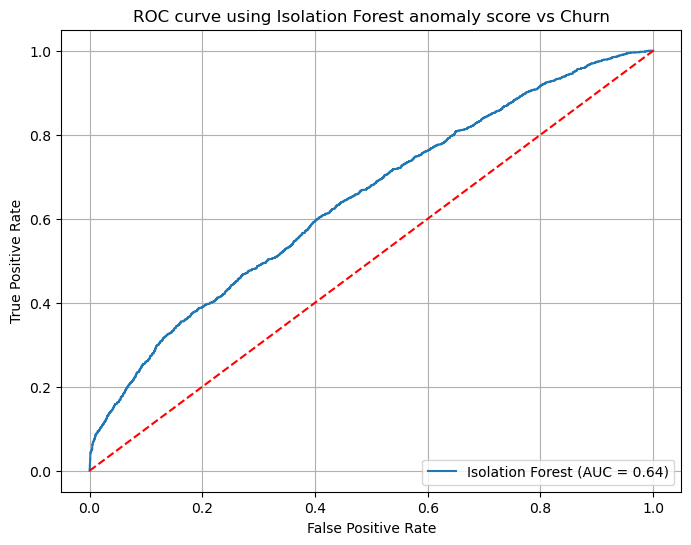

In [5]:
# =============================================================================
# 2. Unsupervised anomaly detection (Isolation Forest + LOF)
# =============================================================================

# We use all preprocessed features X (numeric Gender + Geography dummies)
# and standardize them for anomaly detection algorithms
scaler_anom = StandardScaler()
X_anom_scaled = scaler_anom.fit_transform(X)

# %%
# === 1) Isolation Forest ===
iso = IsolationForest(
    n_estimators=200,
    contamination="auto",  # let the model estimate the fraction of anomalies
    random_state=42,
)
iso.fit(X_anom_scaled)

# score_samples: lower values => more anomalous
iso_raw_scores = iso.score_samples(X_anom_scaled)
iso_scores = -iso_raw_scores  # invert the sign: higher = more anomalous

# Define anomalies as the top 5% most anomalous points (threshold can be tuned)
threshold_iso = np.percentile(iso_scores, 97.5)
iso_anomaly_flag = (iso_scores >= threshold_iso).astype(int)

print(
    f"Isolation Forest - % points marked as anomalies (top 5%): {iso_anomaly_flag.mean()*100:.2f}%"
)

# %%
# === 2) Local Outlier Factor (LOF) ===
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.025,  # ~5% expected anomalies
    novelty=False,  # classic mode: fit_predict on the entire dataset
)
lof_labels = lof.fit_predict(X_anom_scaled)  # -1 = outlier, 1 = inlier
lof_anomaly_flag = (lof_labels == -1).astype(int)

print(f"LOF - % points marked as anomalies: {lof_anomaly_flag.mean()*100:.2f}%")

# Add anomaly information to a copy of the original dataframe
df_anom = df.copy()
df_anom["iso_score"] = iso_scores
df_anom["iso_anomaly"] = iso_anomaly_flag
df_anom["lof_anomaly"] = lof_anomaly_flag

# %%
# Comparison of churn rate between anomalies and non-anomalies
for col in ["iso_anomaly", "lof_anomaly"]:
    print(f"\n=== {col} ===")
    print(df_anom.groupby(col)["Churn"].agg(["mean", "count"]))

# %%
# Isolation Forest: ROC curve using anomaly score vs Churn
fpr_iso, tpr_iso, _ = roc_curve(y, iso_scores)
roc_auc_iso = auc(fpr_iso, tpr_iso)

plt.figure(figsize=(8, 6))
plt.plot(fpr_iso, tpr_iso, label=f"Isolation Forest (AUC = {roc_auc_iso:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve using Isolation Forest anomaly score vs Churn")
plt.legend(loc="lower right")
plt.grid()
plt.show()

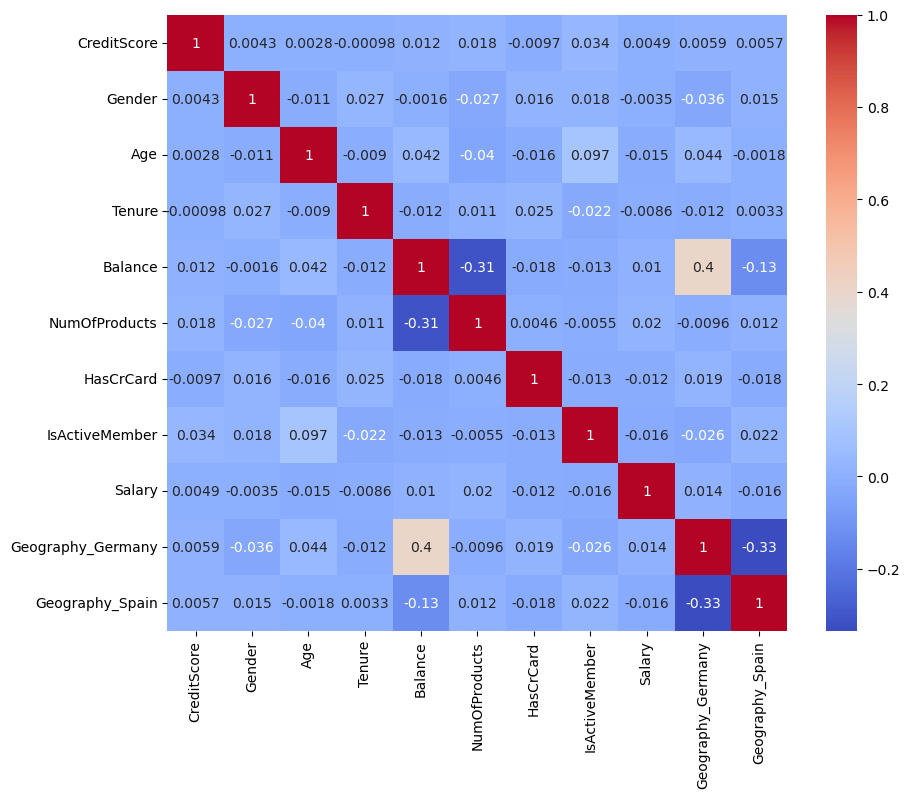

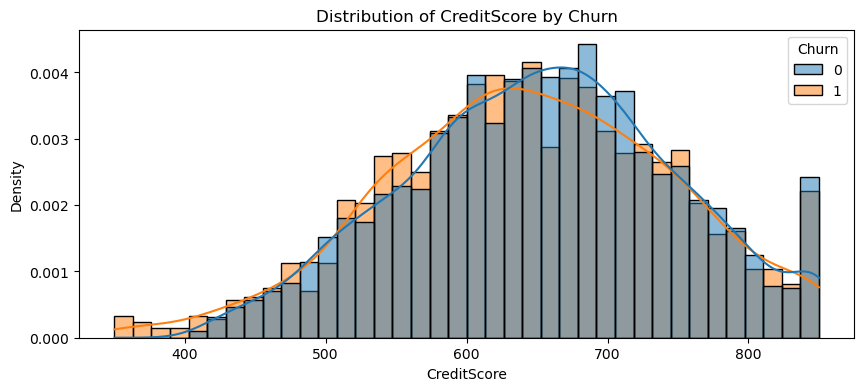

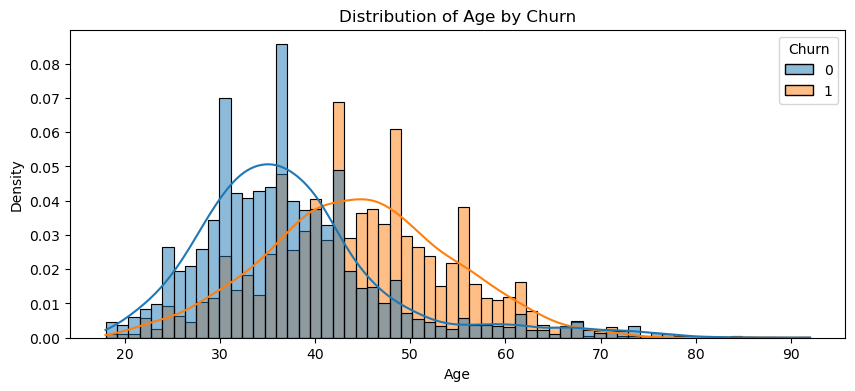

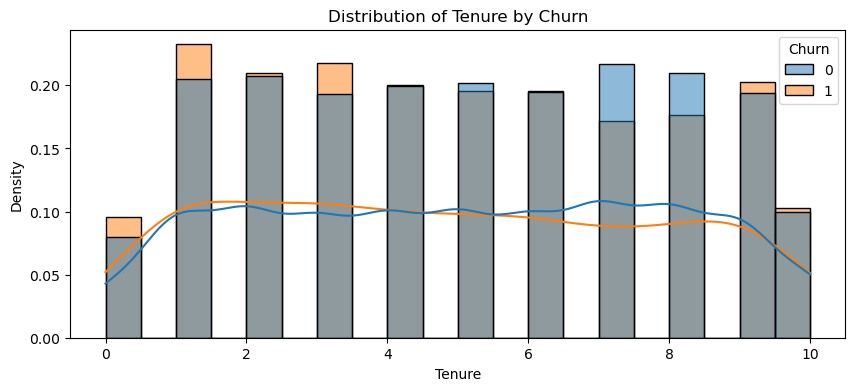

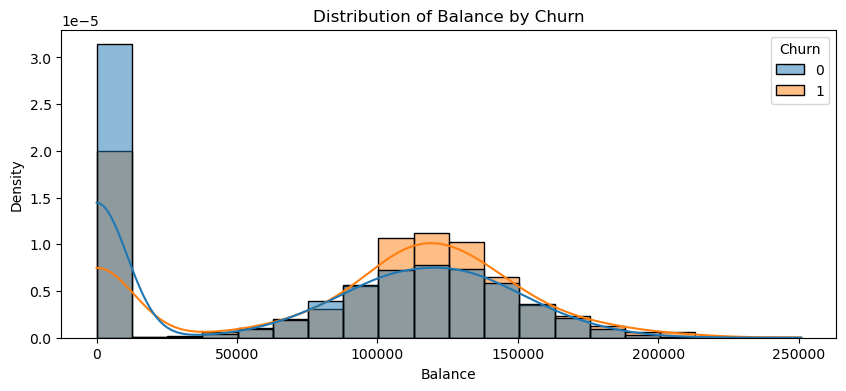

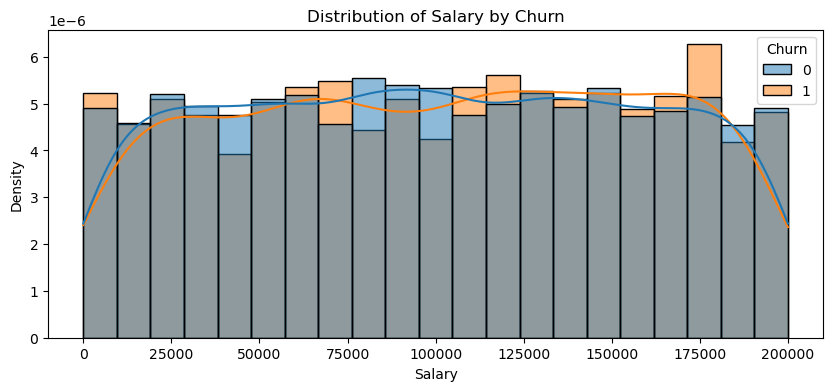

In [6]:
# =============================================================================
# 3. Train-test split for supervised models
# =============================================================================

# %%
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Correlation heatmap on training data
corr = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

# Feature distributions by churn
for col in ["CreditScore", "Age", "Tenure", "Balance", "Salary"]:
    plt.figure(figsize=(10, 4))
    sns.histplot(
        data=df,
        x=col,
        hue="Churn",
        kde=True,
        stat="density",
        common_norm=False,
    )
    plt.title(f"Distribution of {col} by Churn")
    plt.show()


=== GaussianNB ===
Accuracy: 0.7137
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1278
           1       0.38      0.67      0.49       322

    accuracy                           0.71      1600
   macro avg       0.64      0.70      0.64      1600
weighted avg       0.79      0.71      0.74      1600

Confusion Matrix:
[[926 352]
 [106 216]]


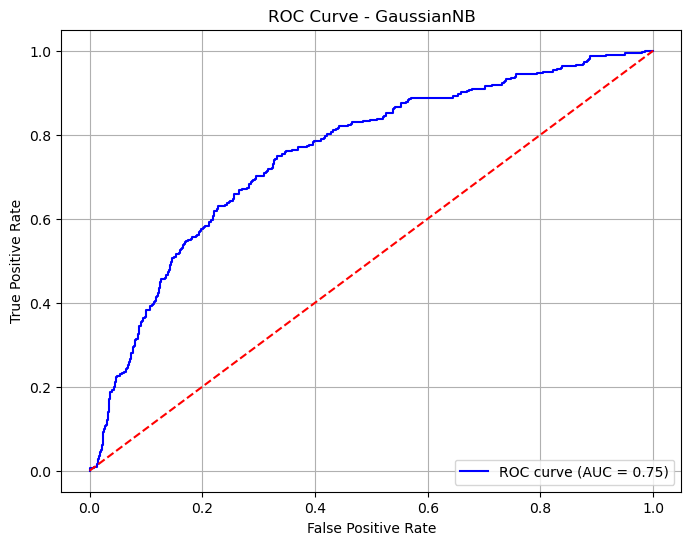


=== LDA ===
Accuracy: 0.7281
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1278
           1       0.40      0.70      0.51       322

    accuracy                           0.73      1600
   macro avg       0.65      0.72      0.66      1600
weighted avg       0.80      0.73      0.75      1600

Confusion Matrix:
[[940 338]
 [ 97 225]]


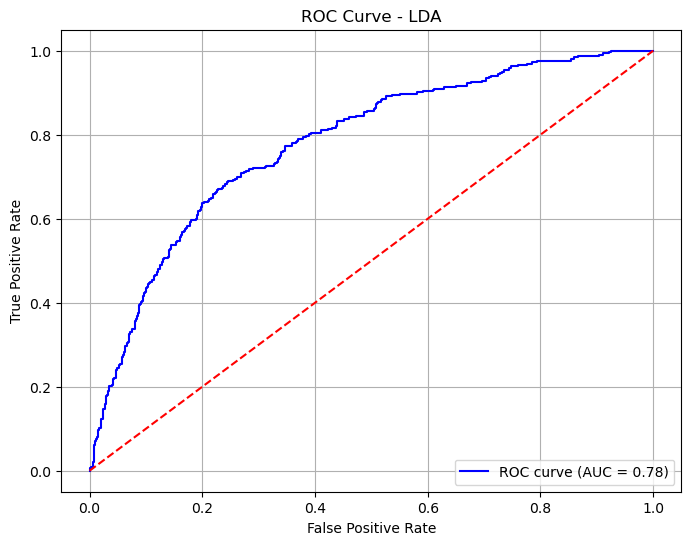


=== QDA ===
Accuracy: 0.7356
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1278
           1       0.41      0.71      0.52       322

    accuracy                           0.74      1600
   macro avg       0.66      0.73      0.67      1600
weighted avg       0.81      0.74      0.76      1600

Confusion Matrix:
[[947 331]
 [ 92 230]]


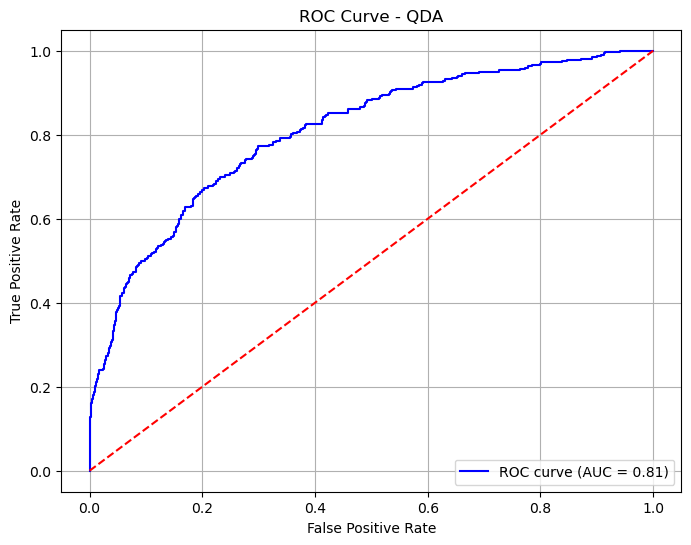


=== Logistic Regression ===
Accuracy: 0.7269
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1278
           1       0.40      0.70      0.51       322

    accuracy                           0.73      1600
   macro avg       0.65      0.72      0.66      1600
weighted avg       0.81      0.73      0.75      1600

Confusion Matrix:
[[936 342]
 [ 95 227]]


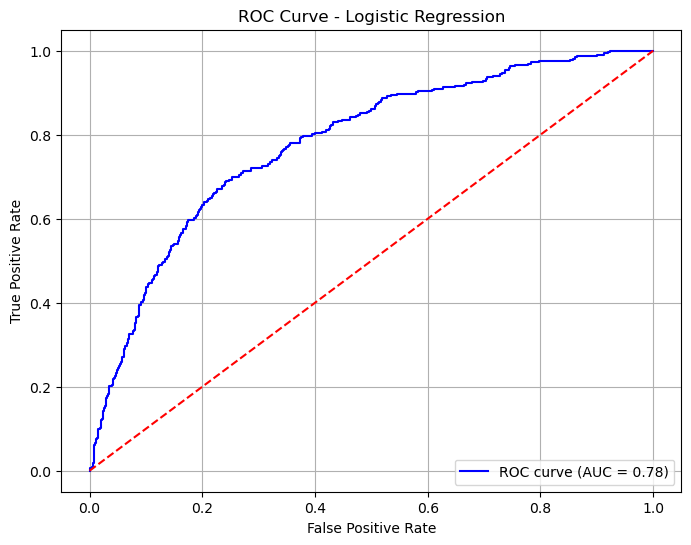


=== KNN ===
Accuracy: 0.7256
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1278
           1       0.40      0.69      0.50       322

    accuracy                           0.73      1600
   macro avg       0.65      0.71      0.66      1600
weighted avg       0.80      0.73      0.75      1600

Confusion Matrix:
[[939 339]
 [100 222]]


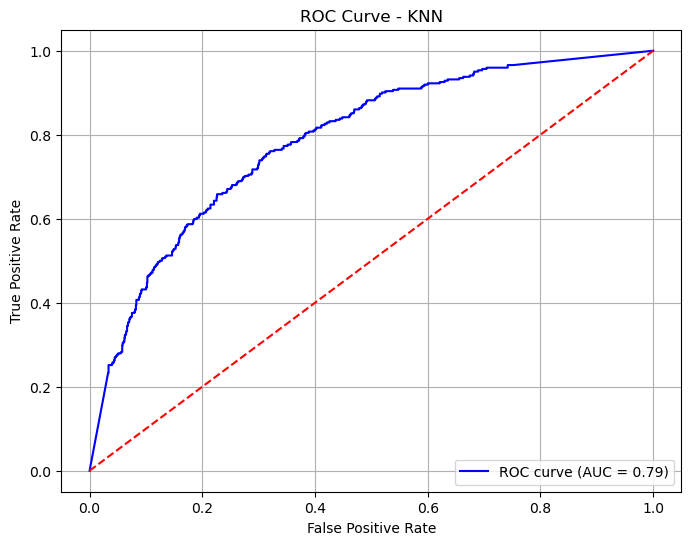


=== Decision Tree ===
Accuracy: 0.7756
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1278
           1       0.46      0.66      0.54       322

    accuracy                           0.78      1600
   macro avg       0.68      0.73      0.70      1600
weighted avg       0.81      0.78      0.79      1600

Confusion Matrix:
[[1028  250]
 [ 109  213]]


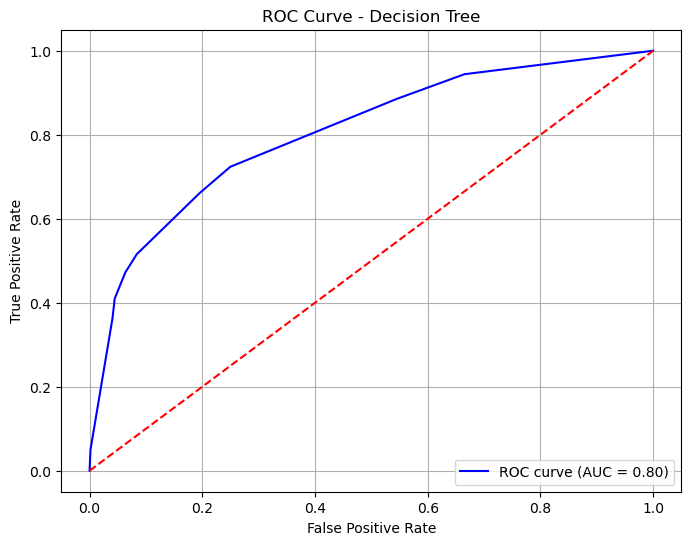


=== Bagging (Decision Trees) ===
Accuracy: 0.7775
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1278
           1       0.47      0.72      0.56       322

    accuracy                           0.78      1600
   macro avg       0.69      0.76      0.71      1600
weighted avg       0.83      0.78      0.79      1600

Confusion Matrix:
[[1013  265]
 [  91  231]]


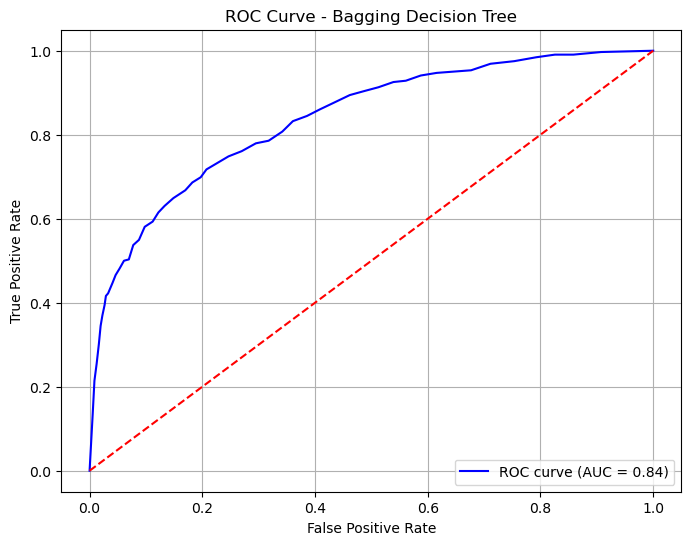


=== Random Forest ===
Accuracy: 0.7825
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1278
           1       0.47      0.75      0.58       322

    accuracy                           0.78      1600
   macro avg       0.70      0.77      0.72      1600
weighted avg       0.84      0.78      0.80      1600

Confusion Matrix:
[[1010  268]
 [  80  242]]


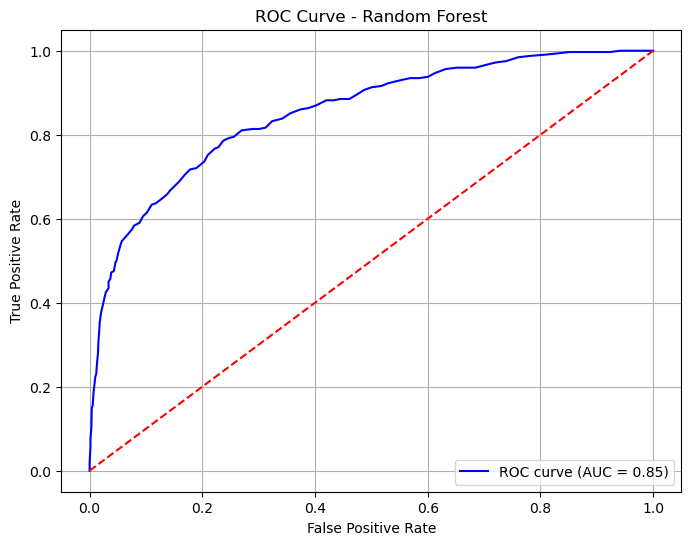


=== Extra Trees ===
Accuracy: 0.7669
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1278
           1       0.45      0.76      0.57       322

    accuracy                           0.77      1600
   macro avg       0.69      0.76      0.70      1600
weighted avg       0.83      0.77      0.79      1600

Confusion Matrix:
[[982 296]
 [ 77 245]]


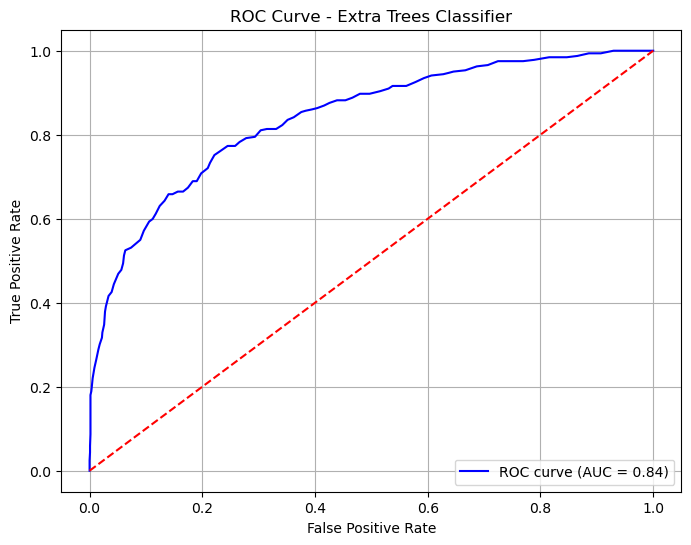


=== AdaBoost ===
Accuracy: 0.7769
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      1278
           1       0.47      0.75      0.57       322

    accuracy                           0.78      1600
   macro avg       0.70      0.77      0.71      1600
weighted avg       0.83      0.78      0.79      1600

Confusion Matrix:
[[1003  275]
 [  82  240]]


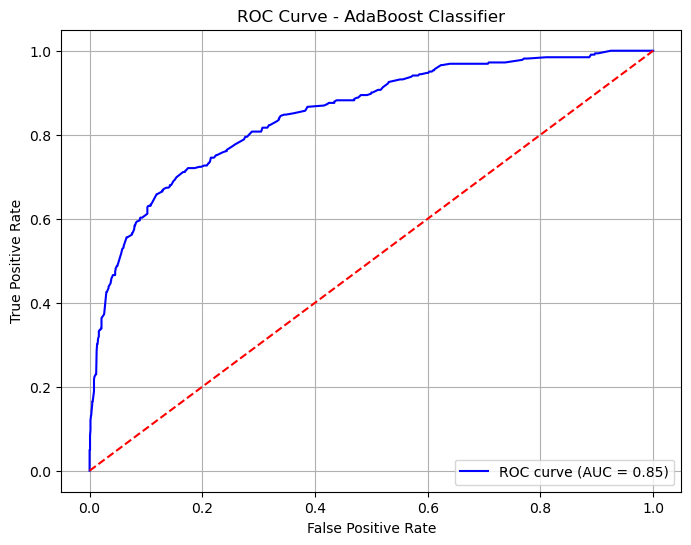


=== Gradient Boosting ===
Accuracy: 0.7881
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1278
           1       0.48      0.75      0.59       322

    accuracy                           0.79      1600
   macro avg       0.71      0.78      0.72      1600
weighted avg       0.84      0.79      0.80      1600

Confusion Matrix:
[[1018  260]
 [  79  243]]


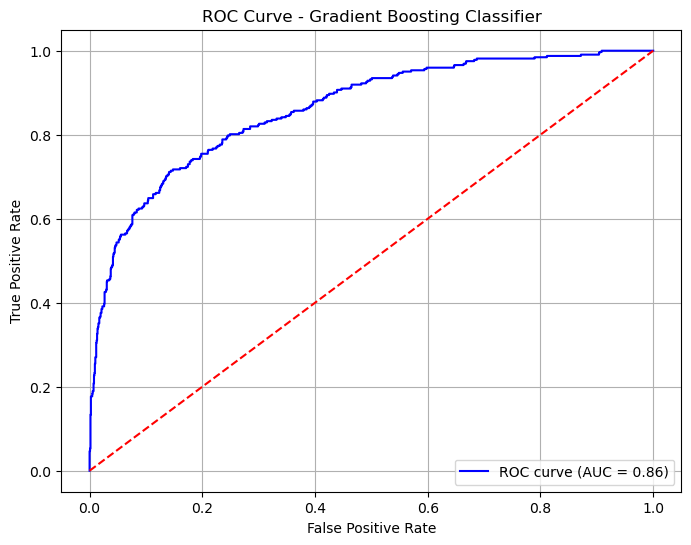


=== Stacking Classifier ===
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1278
           1       0.48      0.77      0.59       322

    accuracy                           0.79      1600
   macro avg       0.71      0.78      0.73      1600
weighted avg       0.84      0.79      0.80      1600

ROC-AUC: 0.8619154540771196


In [10]:
# =============================================================================
# 4. Supervised models on base features (single train/test split)
# =============================================================================

# Standard scaler for models that require scaling (logreg, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------------------------------------------------------
# 4.1 Gaussian Naive Bayes
# -----------------------------------------------------------------------------
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\n=== GaussianNB ===")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

y_prob = gnb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GaussianNB")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 4.2 Linear Discriminant Analysis
# -----------------------------------------------------------------------------
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)

print("\n=== LDA ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lda):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lda))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lda))

y_prob_lda = lda.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lda)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LDA")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 4.3 Quadratic Discriminant Analysis
# -----------------------------------------------------------------------------
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)

print("\n=== QDA ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_qda):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_qda))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_qda))

y_prob_qda = qda.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_qda)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - QDA")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 4.4 Logistic Regression (with scaling)
# -----------------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)

print("\n=== Logistic Regression ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 4.5 KNN (with scaling)
# -----------------------------------------------------------------------------
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print("\n=== KNN ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_knn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 4.6 Decision Tree
# -----------------------------------------------------------------------------
dt = DecisionTreeClassifier(
    criterion="gini", max_depth=20, max_leaf_nodes=10, random_state=42
)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\n=== Decision Tree ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

y_prob_dt = dt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 4.7 Bagging (Decision Trees)
# -----------------------------------------------------------------------------
bagging_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion="gini", random_state=42),
    n_estimators=50,
    random_state=42,
)
bagging_dt.fit(X_train, y_train)
y_pred_bagging = bagging_dt.predict(X_test)

print("\n=== Bagging (Decision Trees) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_bagging):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_bagging))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_bagging))

y_prob_bagging = bagging_dt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_bagging)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Bagging Decision Tree")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 4.8 Random Forest
# -----------------------------------------------------------------------------
rf = RandomForestClassifier(criterion="gini", random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 4.9 Extra Trees
# -----------------------------------------------------------------------------
etf = ExtraTreesClassifier(criterion="gini", random_state=42)
etf.fit(X_train, y_train)
y_pred_etf = etf.predict(X_test)

print("\n=== Extra Trees ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_etf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_etf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_etf))

y_prob_etf = etf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_etf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Extra Trees Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 4.10 AdaBoost
# -----------------------------------------------------------------------------
adb = AdaBoostClassifier(n_estimators=100, random_state=42)
adb.fit(X_train, y_train)
y_pred_adb = adb.predict(X_test)

print("\n=== AdaBoost ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adb):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_adb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adb))

y_prob_adb = adb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_adb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 4.11 Gradient Boosting
# -----------------------------------------------------------------------------
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

print("\n=== Gradient Boosting ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gbc):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_gbc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbc))

y_prob_gbc = gbc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gbc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# -----------------------------------------------------------------------------
# 4.12 Stacking Classifier
# -----------------------------------------------------------------------------
base_learners = [
    # Linear / probabilistic models
    ("gnb", GaussianNB()),
    ("lda", LinearDiscriminantAnalysis()),
    ("qda", QuadraticDiscriminantAnalysis()),
    (
        "lr",
        Pipeline(
            [
                ("scaler", StandardScaler()),
                ("lr_model", LogisticRegression(max_iter=1000, class_weight="balanced")),
            ]
        ),
    ),
    # Tree-based / ensemble models
    ("dt", DecisionTreeClassifier(max_depth=5, random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("gb", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("ab", AdaBoostClassifier(n_estimators=100, random_state=42)),
    # Instance-based
    (
        "knn",
        Pipeline(
            [
                ("scaler", StandardScaler()),
                ("knn_model", KNeighborsClassifier(n_neighbors=5, weights="distance")),
            ]
        ),
    ),
]

meta_learner = LogisticRegression(max_iter=1000)

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=None,  # no internal CV, fit directly on the training set
)

stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)
y_prob_stack = stack_model.predict_proba(X_test)[:, 1]

print("\n=== Stacking Classifier ===")
print("Classification Report:")
print(classification_report(y_test, y_pred_stack))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_stack))

In [11]:
# =============================================================================
# 5. Summary table on test set (single split)
# =============================================================================

models_info = [
    ("GaussianNB", gnb, X_test),
    ("LDA", lda, X_test),
    ("QDA", qda, X_test),
    ("Logistic Regression", logreg, X_test_scaled),
    ("KNN", knn, X_test_scaled),
    ("Decision Tree", dt, X_test),
    ("Bagging DT", bagging_dt, X_test),
    ("Random Forest", rf, X_test),
    ("Extra Trees", etf, X_test),
    ("AdaBoost", adb, X_test),
    ("Gradient Boosting", gbc, X_test),
    ("Stacking", stack_model, X_test),
]

results = []

for name, model, X_te in models_info:
    y_pred = model.predict(X_te)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_te)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append(
        {
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-score": f1,
            "ROC-AUC": roc_auc,
        }
    )

summary_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
print("\n=== Test-set performance (single split) ===")
print(summary_df)


=== Test-set performance (single split) ===
                  Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
11             Stacking  0.787500   0.482558  0.773292  0.594272  0.861915
10    Gradient Boosting  0.788125   0.483101  0.754658  0.589091  0.861457
7         Random Forest  0.782500   0.474510  0.751553  0.581731  0.851736
9              AdaBoost  0.776875   0.466019  0.745342  0.573477  0.849209
8           Extra Trees  0.766875   0.452865  0.760870  0.567787  0.839847
6            Bagging DT  0.777500   0.465726  0.717391  0.564792  0.837060
2                   QDA  0.735625   0.409982  0.714286  0.520951  0.807079
5         Decision Tree  0.775625   0.460043  0.661491  0.542675  0.804224
4                   KNN  0.725625   0.395722  0.689441  0.502831  0.786756
3   Logistic Regression  0.726875   0.398946  0.704969  0.509540  0.779182
1                   LDA  0.728125   0.399645  0.698758  0.508475  0.778755
0            GaussianNB  0.713750   0.380282  0.670807 

In [9]:
# =============================================================================
# 6. Cross-validation evaluation (Stratified K-Fold)
# =============================================================================

# We perform 5-fold stratified CV on the training set for the main models.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_models = [
    ("Decision Tree", dt),
    ("Bagging DT", bagging_dt),
    ("Random Forest", rf),
    ("Extra Trees", etf),
    ("AdaBoost", adb),
    ("Gradient Boosting", gbc),
    ("Stacking", stack_model),
]

cv_results = []

for name, model in cv_models:
    # For tree-based models we can use raw features X_train (no scaling needed)
    scores = cross_val_score(
        model, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1
    )
    cv_results.append(
        {
            "Model": name,
            "CV ROC-AUC mean": scores.mean(),
            "CV ROC-AUC std": scores.std(),
        }
    )

cv_df = pd.DataFrame(cv_results).sort_values(by="CV ROC-AUC mean", ascending=False)
print("\n=== Cross-validation performance (5-fold, training set) ===")
print(cv_df)



=== Cross-validation performance (5-fold, training set) ===
               Model  CV ROC-AUC mean  CV ROC-AUC std
5  Gradient Boosting         0.862315        0.011158
6           Stacking         0.862107        0.009330
2      Random Forest         0.848897        0.007224
3        Extra Trees         0.843305        0.006657
4           AdaBoost         0.841124        0.010631
1         Bagging DT         0.838706        0.009797
0      Decision Tree         0.810724        0.013077


In [10]:
# =============================================================================
# 7. Adding anomaly features and retraining models (optional analysis)
# =============================================================================

# 7.1 Add anomaly flags as features
X_enhanced = X.copy()
X_enhanced["iso_anomaly"] = iso_anomaly_flag
X_enhanced["lof_anomaly"] = lof_anomaly_flag

# 7.2 New train-test split with anomaly features
X_train_anom, X_test_anom, y_train_anom, y_test_anom = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42, stratify=y
)


scaler_anom = StandardScaler()
X_train_anom_scaled = scaler_anom.fit_transform(X_train_anom)
X_test_anom_scaled = scaler_anom.transform(X_test_anom)

# 7.3 Retrain models with anomaly features (same structure as before)
gnb_anom = GaussianNB().fit(X_train_anom, y_train_anom)
lda_anom = LinearDiscriminantAnalysis().fit(X_train_anom, y_train_anom)
qda_anom = QuadraticDiscriminantAnalysis().fit(X_train_anom, y_train_anom)

logreg_anom = LogisticRegression(max_iter=1000, class_weight="balanced")
logreg_anom.fit(X_train_anom_scaled, y_train_anom)

knn_anom = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn_anom.fit(X_train_anom_scaled, y_train_anom)

dt_anom = DecisionTreeClassifier(
    criterion="gini", max_depth=20, max_leaf_nodes=10, random_state=42
).fit(X_train_anom, y_train_anom)

bagging_dt_anom = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion="gini", random_state=42),
    n_estimators=50,
    random_state=42,
).fit(X_train_anom, y_train_anom)

rf_anom = RandomForestClassifier(criterion="gini", random_state=42).fit(
    X_train_anom, y_train_anom
)
etf_anom = ExtraTreesClassifier(criterion="gini", random_state=42).fit(
    X_train_anom, y_train_anom
)
adb_anom = AdaBoostClassifier(n_estimators=100, random_state=42).fit(
    X_train_anom, y_train_anom
)
gbc_anom = GradientBoostingClassifier(n_estimators=100, random_state=42).fit(
    X_train_anom, y_train_anom
)

base_learners_anom = [
    ("gnb", GaussianNB()),
    ("lda", LinearDiscriminantAnalysis()),
    ("qda", QuadraticDiscriminantAnalysis()),
    (
        "lr",
        Pipeline(
            [
                ("scaler", StandardScaler()),
                ("lr_model", LogisticRegression(max_iter=1000, class_weight="balanced")),
            ]
        ),
    ),
    ("dt", DecisionTreeClassifier(max_depth=5, random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("gb", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("ab", AdaBoostClassifier(n_estimators=100, random_state=42)),
    (
        "knn",
        Pipeline(
            [
                ("scaler", StandardScaler()),
                ("knn_model", KNeighborsClassifier(n_neighbors=5, weights="distance")),
            ]
        ),
    ),
]

meta_learner_anom = LogisticRegression(max_iter=1000)

stack_model_anom = StackingClassifier(
    estimators=base_learners_anom,
    final_estimator=meta_learner_anom,
    cv=None,
).fit(X_train_anom, y_train_anom)

models_info_anom = [
    ("GaussianNB", gnb_anom, X_test_anom),
    ("LDA", lda_anom, X_test_anom),
    ("QDA", qda_anom, X_test_anom),
    ("Logistic Regression", logreg_anom, X_test_anom_scaled),
    ("KNN", knn_anom, X_test_anom_scaled),
    ("Decision Tree", dt_anom, X_test_anom),
    ("Bagging DT", bagging_dt_anom, X_test_anom),
    ("Random Forest", rf_anom, X_test_anom),
    ("Extra Trees", etf_anom, X_test_anom),
    ("AdaBoost", adb_anom, X_test_anom),
    ("Gradient Boosting", gbc_anom, X_test_anom),
    ("Stacking", stack_model_anom, X_test_anom),
]

results_anom = []

for name, model, X_te in models_info_anom:
    y_pred = model.predict(X_te)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_te)[:, 1]
        roc_auc = roc_auc_score(y_test_anom, y_prob)
    else:
        roc_auc = None

    acc = accuracy_score(y_test_anom, y_pred)
    prec = precision_score(y_test_anom, y_pred)
    rec = recall_score(y_test_anom, y_pred)
    f1 = f1_score(y_test_anom, y_pred)

    results_anom.append(
        {
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-score": f1,
            "ROC-AUC": roc_auc,
        }
    )

summary_df_anom = pd.DataFrame(results_anom).sort_values(
    by="ROC-AUC", ascending=False
)
print("\n=== Performance with anomaly features ===")
print(summary_df_anom)

# Compare base vs anomaly-augmented models
try:
    comparison_df = summary_df.merge(
        summary_df_anom, on="Model", suffixes=("_base", "_anom")
    )
    print("\n=== Comparison base vs with anomalies ===")
    print(comparison_df)
except NameError:
    print(
        "summary_df (base) is not defined in this kernel: run the cell that calculates it first."
    )


=== Performance with anomaly features ===
                  Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
10    Gradient Boosting  0.869375   0.789744  0.478261  0.595745  0.867508
11             Stacking  0.868125   0.768116  0.493789  0.601134  0.862963
7         Random Forest  0.868750   0.791667  0.472050  0.591440  0.843711
9              AdaBoost  0.856875   0.733668  0.453416  0.560461  0.840706
6            Bagging DT  0.857500   0.713636  0.487578  0.579336  0.833699
8           Extra Trees  0.859375   0.753927  0.447205  0.561404  0.833388
2                   QDA  0.816875   0.674699  0.173913  0.276543  0.815273
5         Decision Tree  0.856875   0.736041  0.450311  0.558767  0.810419
3   Logistic Regression  0.737500   0.409594  0.689441  0.513889  0.800404
1                   LDA  0.820625   0.669903  0.214286  0.324706  0.797403
4                   KNN  0.831875   0.629268  0.400621  0.489564  0.783193
0            GaussianNB  0.792500   0.391304  0.055901  0

In [11]:
# =============================================================================
# 8. Hyperparameter tuning for key models (with internal 5-fold CV)
# =============================================================================

# Note: RandomizedSearchCV below uses 5-fold CV with ROC-AUC as the scoring metric.
# We tune: Gradient Boosting, Random Forest, AdaBoost, Extra Trees, Stacking.

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 8.1 Gradient Boosting tuning
gb = GradientBoostingClassifier(random_state=42)

param_dist_gb = {
    "n_estimators": randint(50, 301),          # number of boosting stages
    "learning_rate": uniform(0.01, 0.19),      # shrinkage rate [0.01, 0.20]
    "max_depth": randint(2, 6),                # depth of individual trees
    "subsample": uniform(0.6, 0.4),            # subsampling fraction [0.6, 1.0]
    "min_samples_split": randint(2, 11),       # min samples to split an internal node
    "min_samples_leaf": randint(1, 11),        # min samples at a leaf
}

gb_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist_gb,
    n_iter=40,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

gb_search.fit(X_train, y_train)

print("\n=== Best Gradient Boosting params ===")
print(gb_search.best_params_)
print("Best CV ROC-AUC:", gb_search.best_score_)

gb_best = gb_search.best_estimator_
y_prob_gb_best = gb_best.predict_proba(X_test)[:, 1]
y_pred_gb_best = gb_best.predict(X_test)

print("\n=== Gradient Boosting tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_gb_best))
print("Precision:", precision_score(y_test, y_pred_gb_best))
print("Recall:", recall_score(y_test, y_pred_gb_best))
print("F1-score:", f1_score(y_test, y_pred_gb_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_gb_best))


# 8.2 Random Forest tuning
rf_tune = RandomForestClassifier(random_state=42, n_jobs=-1)

param_dist_rf = {
    "n_estimators": randint(100, 401),         # number of trees
    "max_depth": [None] + list(range(3, 11)),  # tree depth
    "min_samples_split": randint(2, 21),
    "min_samples_leaf": randint(1, 21),
    "max_features": ["sqrt", "log2", 0.5, 0.7, None],
    "class_weight": [None, "balanced", "balanced_subsample"],
}

rf_search = RandomizedSearchCV(
    estimator=rf_tune,
    param_distributions=param_dist_rf,
    n_iter=40,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

rf_search.fit(X_train, y_train)

print("\n=== Best Random Forest params ===")
print(rf_search.best_params_)
print("Best CV ROC-AUC:", rf_search.best_score_)

rf_best = rf_search.best_estimator_
y_prob_rf_best = rf_best.predict_proba(X_test)[:, 1]
y_pred_rf_best = rf_best.predict(X_test)

print("\n=== Random Forest tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_best))
print("Precision:", precision_score(y_test, y_pred_rf_best))
print("Recall:", precision_score(y_test, y_pred_rf_best))
print("F1-score:", f1_score(y_test, y_pred_rf_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf_best))


# 8.3 AdaBoost tuning
adb_tune = AdaBoostClassifier(random_state=42)

param_dist_adb = {
    "n_estimators": randint(50, 301),          # number of weak learners
    "learning_rate": uniform(0.01, 0.99),      # step size [0.01, 1.0]
}

adb_search = RandomizedSearchCV(
    estimator=adb_tune,
    param_distributions=param_dist_adb,
    n_iter=40,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

adb_search.fit(X_train, y_train)

print("\n=== Best AdaBoost params ===")
print(adb_search.best_params_)
print("Best CV ROC-AUC:", adb_search.best_score_)

adb_best = adb_search.best_estimator_
y_prob_adb_best = adb_best.predict_proba(X_test)[:, 1]
y_pred_adb_best = adb_best.predict(X_test)

print("\n=== AdaBoost tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_adb_best))
print("Precision:", precision_score(y_test, y_pred_adb_best))
print("Recall:", recall_score(y_test, y_pred_adb_best))
print("F1-score:", f1_score(y_test, y_pred_adb_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_adb_best))


# 8.4 Extra Trees tuning
et_tune = ExtraTreesClassifier(random_state=42, n_jobs=-1)

param_dist_et = {
    "n_estimators": randint(100, 401),
    "max_depth": [None] + list(range(3, 11)),
    "min_samples_split": randint(2, 21),
    "min_samples_leaf": randint(1, 21),
    "max_features": ["sqrt", "log2", 0.5, 0.7, None],
    "bootstrap": [True, False],
}

et_search = RandomizedSearchCV(
    estimator=et_tune,
    param_distributions=param_dist_et,
    n_iter=40,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

et_search.fit(X_train, y_train)

print("\n=== Best Extra Trees params ===")
print(et_search.best_params_)
print("Best CV ROC-AUC:", et_search.best_score_)

et_best = et_search.best_estimator_
y_prob_et_best = et_best.predict_proba(X_test)[:, 1]
y_pred_et_best = et_best.predict(X_test)

print("\n=== Extra Trees tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_et_best))
print("Precision:", precision_score(y_test, y_pred_et_best))
print("Recall:", recall_score(y_test, y_pred_et_best))
print("F1-score:", f1_score(y_test, y_pred_et_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_et_best))


# 8.5 Stacking Classifier tuning
# We reuse the same base_learners defined earlier and tune only the meta-learner (logistic regression).
meta_learner_tune = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear",      # supports L1 and L2 penalty
)

stack_base_learners = base_learners  # reuse your previous list

stack_clf = StackingClassifier(
    estimators=stack_base_learners,
    final_estimator=meta_learner_tune,
    cv=None,                 # no internal CV; RandomizedSearchCV handles CV outside
    n_jobs=-1
)

param_dist_stack = {
    "final_estimator__C": uniform(0.01, 9.99),    # regularization strength
    "final_estimator__penalty": ["l1", "l2"],     # type of penalty
}

stack_search = RandomizedSearchCV(
    estimator=stack_clf,
    param_distributions=param_dist_stack,
    n_iter=30,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

stack_search.fit(X_train, y_train)

print("\n=== Best Stacking params ===")
print(stack_search.best_params_)
print("Best CV ROC-AUC:", stack_search.best_score_)

stack_best = stack_search.best_estimator_
y_prob_stack_best = stack_best.predict_proba(X_test)[:, 1]
y_pred_stack_best = stack_best.predict(X_test)

print("\n=== Stacking tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_stack_best))
print("Precision:", precision_score(y_test, y_pred_stack_best))
print("Recall:", recall_score(y_test, y_pred_stack_best))
print("F1-score:", f1_score(y_test, y_pred_stack_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_stack_best))


Fitting 5 folds for each of 40 candidates, totalling 200 fits

=== Best Gradient Boosting params ===
{'learning_rate': np.float64(0.028995234005420548), 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 149, 'subsample': np.float64(0.6571467271687763)}
Best CV ROC-AUC: 0.8650538479448905

=== Gradient Boosting tuned - Test metrics ===
Accuracy: 0.868125
Precision: 0.7905759162303665
Recall: 0.468944099378882
F1-score: 0.5886939571150097
ROC-AUC: 0.8651692765287377
Fitting 5 folds for each of 40 candidates, totalling 200 fits

=== Best Random Forest params ===
{'class_weight': 'balanced_subsample', 'max_depth': 9, 'max_features': 0.5, 'min_samples_leaf': 9, 'min_samples_split': 18, 'n_estimators': 151}
Best CV ROC-AUC: 0.861565276910157

=== Random Forest tuned - Test metrics ===
Accuracy: 0.825625
Precision: 0.5530864197530864
Recall: 0.5530864197530864
F1-score: 0.6162310866574966
ROC-AUC: 0.8577163463875037
Fitting 5 folds for each of 40 candidates, total

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = gbc.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate F1 score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Best Threshold for F1: {best_threshold}")

# Apply new threshold
y_pred_new = (y_scores >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_new))

Best Threshold for F1: 0.272625173245248
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1278
           1       0.62      0.68      0.65       322

    accuracy                           0.85      1600
   macro avg       0.77      0.79      0.78      1600
weighted avg       0.86      0.85      0.86      1600



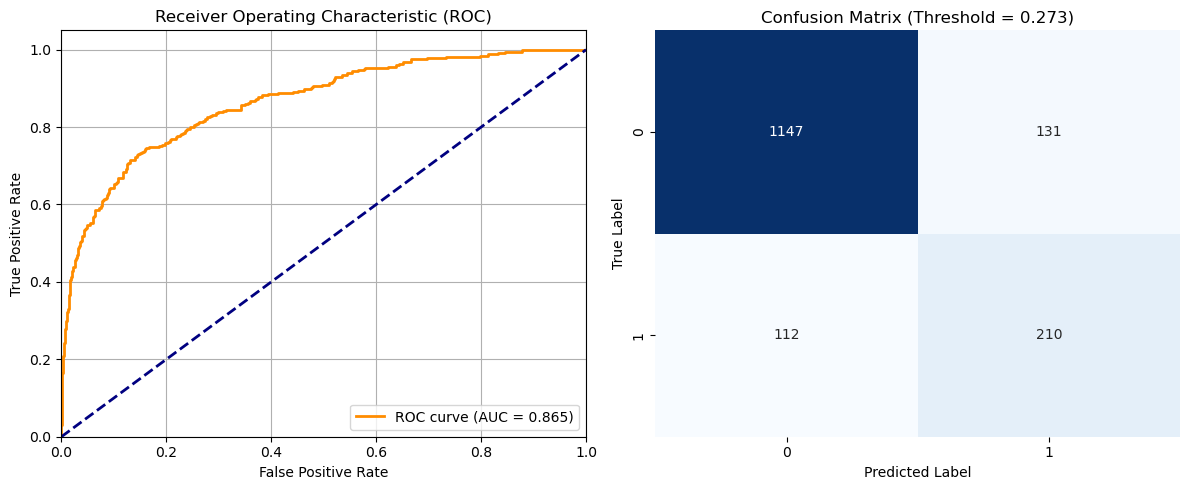


=== Model Performance (Threshold=0.273) ===
ROC-AUC Score: 0.8652
Accuracy:      0.8481
Precision:     0.6158
Recall:        0.6522
F1 Score:      0.6335


In [13]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Calculate Probabilities
y_scores = gb_best.predict_proba(X_test)[:, 1]

# 2. Calculate ROC metrics
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# 3. Plot ROC Curve
plt.figure(figsize=(12, 5))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)

# 4. Confusion Matrix at Best Threshold
# (Using your previously calculated best_threshold)
y_pred_new = (y_scores >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_new)

# Subplot 2: Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Threshold = {best_threshold:.3f})")

plt.tight_layout()
plt.show()

# 5. Print Comprehensive Summary
print(f"\n=== Model Performance (Threshold={best_threshold:.3f}) ===")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Accuracy:      {accuracy_score(y_test, y_pred_new):.4f}")
print(f"Precision:     {precision_score(y_test, y_pred_new):.4f}")
print(f"Recall:        {recall_score(y_test, y_pred_new):.4f}")
print(f"F1 Score:      {f1_score(y_test, y_pred_new):.4f}")